In [1]:
# In this cell we generate the G_ell(F_p) graph

from sage.schemes.elliptic_curves.isogeny_small_degree import isogenies_prime_degree
def findNQR(p):
    for k in range(p):
        if kronecker_symbol(k,p) == -1:
            return k

def gettingGlFp(p, l, steps = oo):
    jInvarList = []
    
    for i in range(p):
        E = EllipticCurve(GF(p), j=i)
        if E.is_supersingular() == True:
            jInvarList.append(i)
    
    jInvarList.sort()
    verticesList = []
    edgeList = []
    infoDic = {}
    seenJInvar = []

    for i in jInvarList:
        if (i%p) != (1728%p):
            E = EllipticCurve(GF(p), j = i)
            ETwist = E.quadratic_twist()
            verticesList.append(E)
            verticesList.append(ETwist)
        if (i%p) == (1728%p):
            D = findNQR(p)
            E = EllipticCurve(GF(p), j = i)
            ETwist = E.quartic_twist(D)
            verticesList.append(E)
            verticesList.append(ETwist)

    for E in verticesList:
        isogList = isogenies_prime_degree(E, l)
        for phi in isogList:
            phiCoDomain = phi.codomain()
            for E1 in verticesList:
                if E1.is_isomorphic(phiCoDomain):
                    edgeList.append([E,E1])
    
    for E in verticesList:
        Ej = E.j_invariant()
        if Ej in seenJInvar:
            infoDic[E] = str(Ej)+'^t'
        else:
            infoDic[E] = str(Ej)
            seenJInvar.append(Ej)
    
    edgeListUncomplicated = []
    for e in edgeList:
        eDomain = e[0]
        eCoDomain = e[1]
        eDomainUC = infoDic[eDomain]
        eCoDomainUC = infoDic[eCoDomain]
        edgeListUncomplicated.append([eDomainUC,eCoDomainUC])
    
    G = DiGraph(multiedges=True,loops=True)
    for e in edgeListUncomplicated:
        G.add_edge(e)      
    
    Gl = G.plot()
    return G

In [2]:
# In this cell we get the graph G_ell(F_pBar)

from sage.modular.ssmod.ssmod import Phi_polys
from sage.graphs.graph_plot import GraphPlot

def build_isogeny_graph_over_Fpbar(p, l, steps=oo):
    q = next(q for q in Primes() if q%4 == 3 and kronecker_symbol(-q,p) == -1)
    K = QuadraticField(-q)
    H = K.hilbert_class_polynomial()
    j0 = H.change_ring(GF(p^2)).any_root()
    
    def get_neighbors(j):
        R.<x> = GF(p^2)[]
        phi = Phi_polys(l,x,j)
        return flatten([[j2]*k for j2,k in phi.roots()])
    G = DiGraph(multiedges=True,loops=True)
    visited = set()
    not_visited = set([j0])
    count = 0
    while not_visited:
        j1 = not_visited.pop()
        visited.add(j1)
        for j2 in get_neighbors(j1):
            G.add_edge([j1,j2])
            if j2 not in visited and j2 not in not_visited:
                not_visited.add(j2)
        count += 1
        if count == steps:
            break
    Gl = G.plot(vertex_size = 90)
    return G

In [3]:
# In this cell we generate the graph S_ell^p

def directedSpineGraph(p, l, steps = oo):
    D = build_isogeny_graph_over_Fpbar(p, l)
    G = D.copy()
    for j in G.vertices():
        if j not in GF(p):
            G.delete_vertex(j)
    return G

In [4]:
# In this cell we define the function that extends the field an elliptic curve is defined over.

def Extend_EC(EC_over_Fp, p, n):
    a4 = EC_over_Fp.a4()
    a6 = EC_over_Fp.a6()
    ECExtend = EllipticCurve(GF(p^n), (a4,a6))
    return ECExtend

In [5]:
# In this cell we will get all the information about the VERTICES of G_ell(F_p):

#------------------------------------------------------------------------------

# What are the j-invariants in this graph?

def jInvaraintsForGFP(p,ell):
    jInvarList = []
    
    for i in range(p):
        E = EllipticCurve(GF(p), j=i)
        if E.is_supersingular() == True:
            jInvarList.append(i)
    return jInvarList

#------------------------------------------------------------------------------

# What are the elliptic curve representations of the vertices? (include associated j-invar and ell-torsion points)

def ECRepresentationsGFP(p,ell):
    jInvarList = jInvaraintsForGFP(p,ell)
    
    verticesList = []
    
    for i in jInvarList:
        if (i%p) != (1728%p):
            E = EllipticCurve(GF(p), j = i)
            ETwist = E.quadratic_twist()
            verticesList.append(E)
            verticesList.append(ETwist)
        if (i%p) == (1728%p):
            D = findNQR(p)
            E = EllipticCurve(GF(p), j = i)
            ETwist = E.quartic_twist(D)
            verticesList.append(E)
            verticesList.append(ETwist)
    return verticesList

In [6]:
# In this cell we will get all the information about the EDGES of G_ell(F_p):

#------------------------------------------------------------------------------

def IsogeniesGFP(p,ell,n):
    verticesList = ECRepresentationsGFP(p,ell)
    isogINFO = []
    for E in verticesList:
        # Here E is defined over GF(p)
        # We extend the field E is defined over so we can find all the torsion points.
        EExtended = Extend_EC(E,p,n)
        EEx_ell_torsion = [P for P in EExtended if P.order() == ell]
        if len(EEx_ell_torsion) != ell^2-1:
            return "You do not have every ell-torsion point"
        ellIsogList = []
        for P in EEx_ell_torsion:
            phi = EExtended.isogeny(P)
            ellIsogList.append((phi, P))
        # now we have gotten all isogenies of degree ell, 
        # but some may be equivalent, and other may not be defined in Fp.
        ellIsogListOverFp = []
        ellIsogListNotOverFp = []
        for (phi,P) in ellIsogList:
            phiRational = phi.rational_maps()
            truthNumerator0 = ((phiRational[0]).numerator()) in GF(p)['x']
            truthDenominator0 = ((phiRational[0]).denominator()) in GF(p)['x']
            truthNumerator1 = ((phiRational[1]).numerator()) in GF(p)['x,y']
            truthDenominator1 = ((phiRational[1]).denominator()) in GF(p)['x']
            if truthNumerator0 and truthDenominator0 and truthNumerator1 and truthDenominator1:
                ellIsogListOverFp.append((phi,P))
            else:
                ellIsogListNotOverFp.append((phi,P))
        if len(ellIsogList) != len(ellIsogListOverFp) + len(ellIsogListNotOverFp):
            return "You have an error in boolean logic"
        # now we have isolated the isogenies of degree ell defined over Fp
        # but we need to get rid of equivalent isogenies.
        ellIsogListOverFpCondence = []
        ellIsogListOverFpCopy = ellIsogListOverFp[:]
        while ellIsogListOverFpCopy != []:
            (phi,P) = ellIsogListOverFpCopy[0]
            Ptemp = P
            PGroup = []
            while Ptemp != EExtended(0):
                PGroup.append(Ptemp)
                Ptemp = Ptemp + P
            phiCodomain = phi.codomain()
            phiCodomaina4 = phiCodomain.a4()
            phiCodomaina6 = phiCodomain.a6()
            phiCodomainFp = EllipticCurve(GF(p),(phiCodomaina4, phiCodomaina6))
            phiCodomainFp_j = phiCodomainFp.j_invariant()
            phiCEC = []
            for EE in verticesList:
                if EE.is_isomorphic(phiCodomainFp):
                    phiCEC.append(EE)
            ellIsogListOverFpCondence.append((phi,PGroup, phiCEC, phiCodomainFp_j))
            for tup in ellIsogListOverFp:
                if tup[1] in PGroup:
                    ellIsogListOverFpCopy.remove(tup)
        isogINFO.append((E, E.j_invariant(),ellIsogListOverFpCondence))
    # return (E, j, [(phi, [phiKernel], [phiCodomains], phiCodomain_j_invar)])
    return isogINFO
            


In [7]:
# Now we wish to see how the isogeny graph changes as we go from Fp to FpBar

# Suppose we are give IsogeniesGFP(p,ell)
def FpToFpBarInfo(isogeniesGFP,n):
    # We wish to have a list of elliptic curves in G_ell(FpBar)
    # This list will be of the form [(j, [Elliptic_Curves_Fp])]
    Elliptic_Curves_Fp = []
    for i in isogeniesGFP:
        Elliptic_Curves_Fp.append((i[0],i[1]))
    Elliptic_Curves_FpBar = []
    Elliptic_Curves_FpCopy = Elliptic_Curves_Fp[:]
    while Elliptic_Curves_Fp != []:
        (E,j) = Elliptic_Curves_Fp[0]
        isomorphic_Elliptic_curves_Fp_to_E = []
        for i in Elliptic_Curves_FpCopy:
            if j == i[1]:
                isomorphic_Elliptic_curves_Fp_to_E.append(i[0])
                Elliptic_Curves_Fp.remove(i)
        Elliptic_Curves_FpBar.append((j, isomorphic_Elliptic_curves_Fp_to_E))
    # Hence we have now formed the vertex information from Fp to FpBar.
    
    # We now wish to have a list of isogenies in G_ell(F_pBar)
    # This list will be of the form:
    # [[domain.j_invarinat, codomain.j_invariant, [(equivalent Fp isogenies, Fp isogeny kernel)]]
    isogeny_equivalence_class = []
    for (j, FpBar_isomorphic_EC) in Elliptic_Curves_FpBar:
        [E1,E2] = FpBar_isomorphic_EC
        isog_with_domain_E1 = []
        isog_with_domain_E2 = []
        for inf in isogeniesGFP:
            if inf[0] == E1:
                for isog in inf[2]:
                    isog_with_domain_E1.append(isog)
            if inf[0] == E2:
                for isog in inf[2]:
                    isog_with_domain_E2.append(isog)
        potential_equivalent_isog = []
        add_at_the_end = []
        seen_isog = []
        for PHI in isog_with_domain_E1:
            potential_PHI_equiv_class = []
            for PSI in isog_with_domain_E2:
                if PHI[3] == PSI[3]:
                    potential_PHI_equiv_class.append(PSI)
            if potential_PHI_equiv_class != [] and (E1.is_isomorphic(E2) == False):
                potential_equivalent_isog.append((PHI, potential_PHI_equiv_class))
        E1Extended = Extend_EC(E1,p,n)
        E2Extended = Extend_EC(E2,p,n)
        eta_E1_to_E2 = E1Extended.isogeny(E1Extended(0), codomain = E2Extended)
        E1Extended_Automorphisms = E1Extended.automorphisms()
        for (PHI, similar_isogeny_to_Phi) in potential_equivalent_isog:
            Equiv_PHI_isogeny_E1_E2_FpBar = [(PHI[0], PHI[1])]
            kerPhi = PHI[1]
            for PSI in similar_isogeny_to_Phi:
                kerPsi = PSI[1]
                equiv = False
                for P in kerPhi:
                    for aut_E1 in E1Extended_Automorphisms:
                        newP = eta_E1_to_E2(aut_E1(P))
                        if newP in kerPsi:
                            equiv = True
                if equiv:
                    Equiv_PHI_isogeny_E1_E2_FpBar.append((PSI[0], PSI[1]))
                    seen_isog.append(PSI)
                    seen_isog.append(PHI)
            isogeny_equivalence_class.append((j, PHI[3], Equiv_PHI_isogeny_E1_E2_FpBar))
        for PHI in isog_with_domain_E1:
            if PHI not in seen_isog:
                add_at_the_end.append(PHI)
        for PHI in isog_with_domain_E2:
            if PHI not in seen_isog:
                add_at_the_end.append(PHI)
        for PHI in add_at_the_end:
            isogeny_equivalence_class.append((j, PHI[3], [(PHI[0], PHI[1])]))
    return Elliptic_Curves_FpBar, isogeny_equivalence_class

# Note that Elliptic_Curves_FpBar has the structure:
# [(j, [Elliptic_Curves_Fp])]

# Further note that isogeny_equivalence_class has the structure:
# [(domain.j_invarinat, codomain.j_invariant, [(equivalent Fp isogenie, Fp isogeny kernel)])]




In [69]:
p = int(input("What is the value of p? "))
ell = int(input("What is the value of ell? "))
m = int(input("What is the value of n? "))

Fp_isogeny_information = IsogeniesGFP(p,ell,m)
FpBar_EC, FpBar_isogenies = FpToFpBarInfo(Fp_isogeny_information,m)

# Note that the variables above have the following structure:

# Fp_isogeny_information is of the form:
# (E, j, [(phi, [phiKernel], [phiCodomains], phiCodomain_j_invar)])

# FpBar_EC is of the form:
# [(j, [Elliptic_Curves_Fp])]

# FpBar_isogenies is of the form:
# [(domain.j_invarinat, codomain.j_invariant, [(equivalent Fp isogenies, Fp isogeny kernel)])]


# For presentatbility purposes, let us define the following function to save space:
def ECEquation(E):
    Ea4 = E.a4()
    Ea6 = E.a6()
    if Ea4 == 0:
        Eq = "y^2 = x^3 + {0}".format(str(Ea6))
        return Eq
    if Ea6 == 0:
        if Ea4 == 1:
            Eq = "y^2 = x^3 + x"
            return Eq
        else:
            Eq = "y^2 = x^3 + {0}x".format(str(Ea4))
            return Eq
    else:
        Eq = "y^2 = x^3 + {0}x + {1}".format(str(Ea4), str(Ea6))
        return Eq





print()
print("########################################################################################")
print("##################### Information about the vertices of G_ell(F_p) #####################")
print("########################################################################################")
print()
print("There are %i isomorphism classes of Elliptic Curves" %(len(Fp_isogeny_information)))
print()
J_invar_list = jInvaraintsForGFP(p,ell)
for j in J_invar_list:
    cnt_j = 0
    for i in Fp_isogeny_information:
        if i[1] == j:
            cnt_j +=1
    print("{0} of the isomorphism classes of Elliptic Curves have j_invariant {1}".format(cnt_j,j))
    print()
print("Namely we have the following Elliptic Curves representing isomorphism classes:")
print()
Edic = {}
for (j, ECList_j) in FpBar_EC:
    for i in range(len(ECList_j)):
        i1 = i+1
        E_equation = ECEquation(ECList_j[i])
        Edic[ECList_j[i]] = ["E_({0},{1})".format(j, i+1), E_equation, "{0},{1}".format(j, i+1)]
        print("E_({0},{1}): {2} is a representative of one of the isomorphism class of elliptic curves that have j-invariant {3}".format(j, i1, E_equation, j))
        print()      

print("all the {0}-torsion points of the elliptic curves are defined over F_(p^{1}).".format(ell, m))
print()
print("#########################################################################################")
print("###################### Information about the edges of G_ell(F_p) ########################")
print("#########################################################################################")
print()
isogDic = {}
for (E, j, isog) in Fp_isogeny_information:
    if len(isog) == 1:
        print("{0} has 1 outgoing equivalence class of isogenies, namely the isogeny equivalence class with representative Phi_({1})".format(Edic[E][0], Edic[E][2]))
        print("This isogeny is generated by the {0}-torsion point(s) {1}, and has codomain {2}".format(ell, isog[0][1], Edic[isog[0][2][0]][0]))
        print()
        isogDic[isog[0][0]] = ["Phi_({0})".format(Edic[E][2])]
    else:
        print("{0} has {1} outgoing equivalence class of isogenies, namely the isogeny equivalence class with representative".format(Edic[E][0], len(isog)))
        for i in range(len(isog)):
            PHI = isog[i]
            print()
            print(" - Phi_({0},{1}) generated by the {2}-torsion point(s) {3}, and has codomain {4}".format(i, Edic[E][2], ell, PHI[1], Edic[PHI[2][0]][0]))
            isogDic[PHI[0]] = ["Phi_({0},{1})".format(i,Edic[E][2])]
        print()
print()
print("#########################################################################################")
print("#### Information about how the edges of G_ell(Fp) change when going to G_ell(FpBar) #####")
print("#########################################################################################")
print()
for FpBarIsog in FpBar_isogenies:
    domain_j_invar = FpBarIsog[0]
    codomain_j_invar = FpBarIsog[1]
    equivalent_isogenies = FpBarIsog[2]
    print("The following Fp isogenies become equivalent to the FpBar isogeny ([{0}], [{1}]):".format(domain_j_invar, codomain_j_invar))
    for PHI in equivalent_isogenies:
        print(" - {0}".format(isogDic[PHI[0]][0]))
    print()
        



KeyboardInterrupt: Interrupted by user

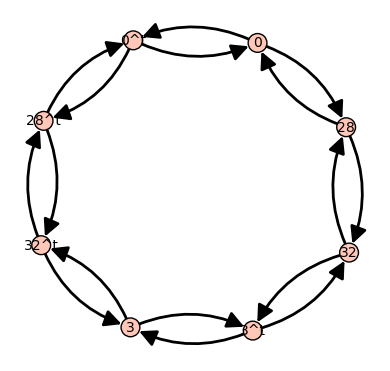

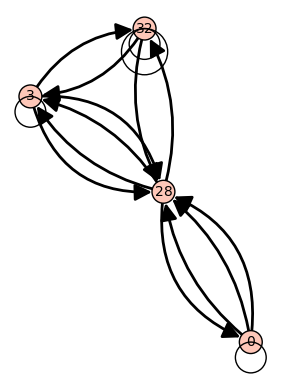

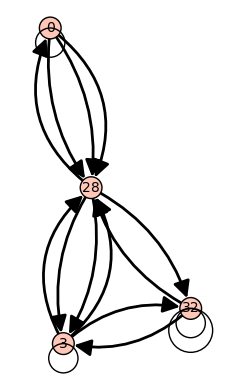

In [68]:
p = 41
ell = 3

GLFP = gettingGlFp(p,ell)
GLFP.show()

SLP = directedSpineGraph(p,ell)
SLP.show()

GLFPB = build_isogeny_graph_over_Fpbar(p,ell)
GLFPB.show()
